In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score, auc, precision_recall_curve
from xgboost import XGBClassifier
import numpy as np

In [ ]:
# Load the dataset
file_path = '/content/sample_data/bank-additional.csv'
data = pd.read_csv(file_path, sep=';')  # Assuming the separator is a semicolon based on the file name

data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [ ]:
# Combine 'basic.4y', 'basic.6y', 'basic.9y' into 'under.high.school' in the education column
data['education'] = data['education'].replace(['basic.4y', 'basic.6y', 'basic.9y'], 'under.high.school')
data['education'].unique()


array(['under.high.school', 'high.school', 'university.degree',
       'professional.course', 'unknown', 'illiterate'], dtype=object)

In [ ]:
# Mapping months to seasons
# Assuming Northern Hemisphere seasonality: Dec-Feb = Winter, Mar-May = Spring, Jun-Aug = Summer, Sep-Nov = Autumn
season_mapping = {
    'mar': 'spring', 'apr': 'spring', 'may': 'spring',
    'jun': 'summer', 'jul': 'summer', 'aug': 'summer',
    'sep': 'autumn', 'oct': 'autumn', 'nov': 'autumn',
    'dec': 'winter', 'jan': 'winter', 'feb': 'winter'
}

# Apply the mapping to the 'month' column
data['season'] = data['month'].map(season_mapping)

# Drop the original 'month' column as it's no longer needed
data.drop('month', axis=1, inplace=True)

# Check the unique values in the 'season' column to verify the transformation
data['season'].unique()

array(['spring', 'summer', 'autumn', 'winter'], dtype=object)

In [ ]:
#remove variable as suggested

data = data.drop(columns=['pdays'])
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'day_of_week', 'duration', 'campaign', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'season'],
      dtype='object')

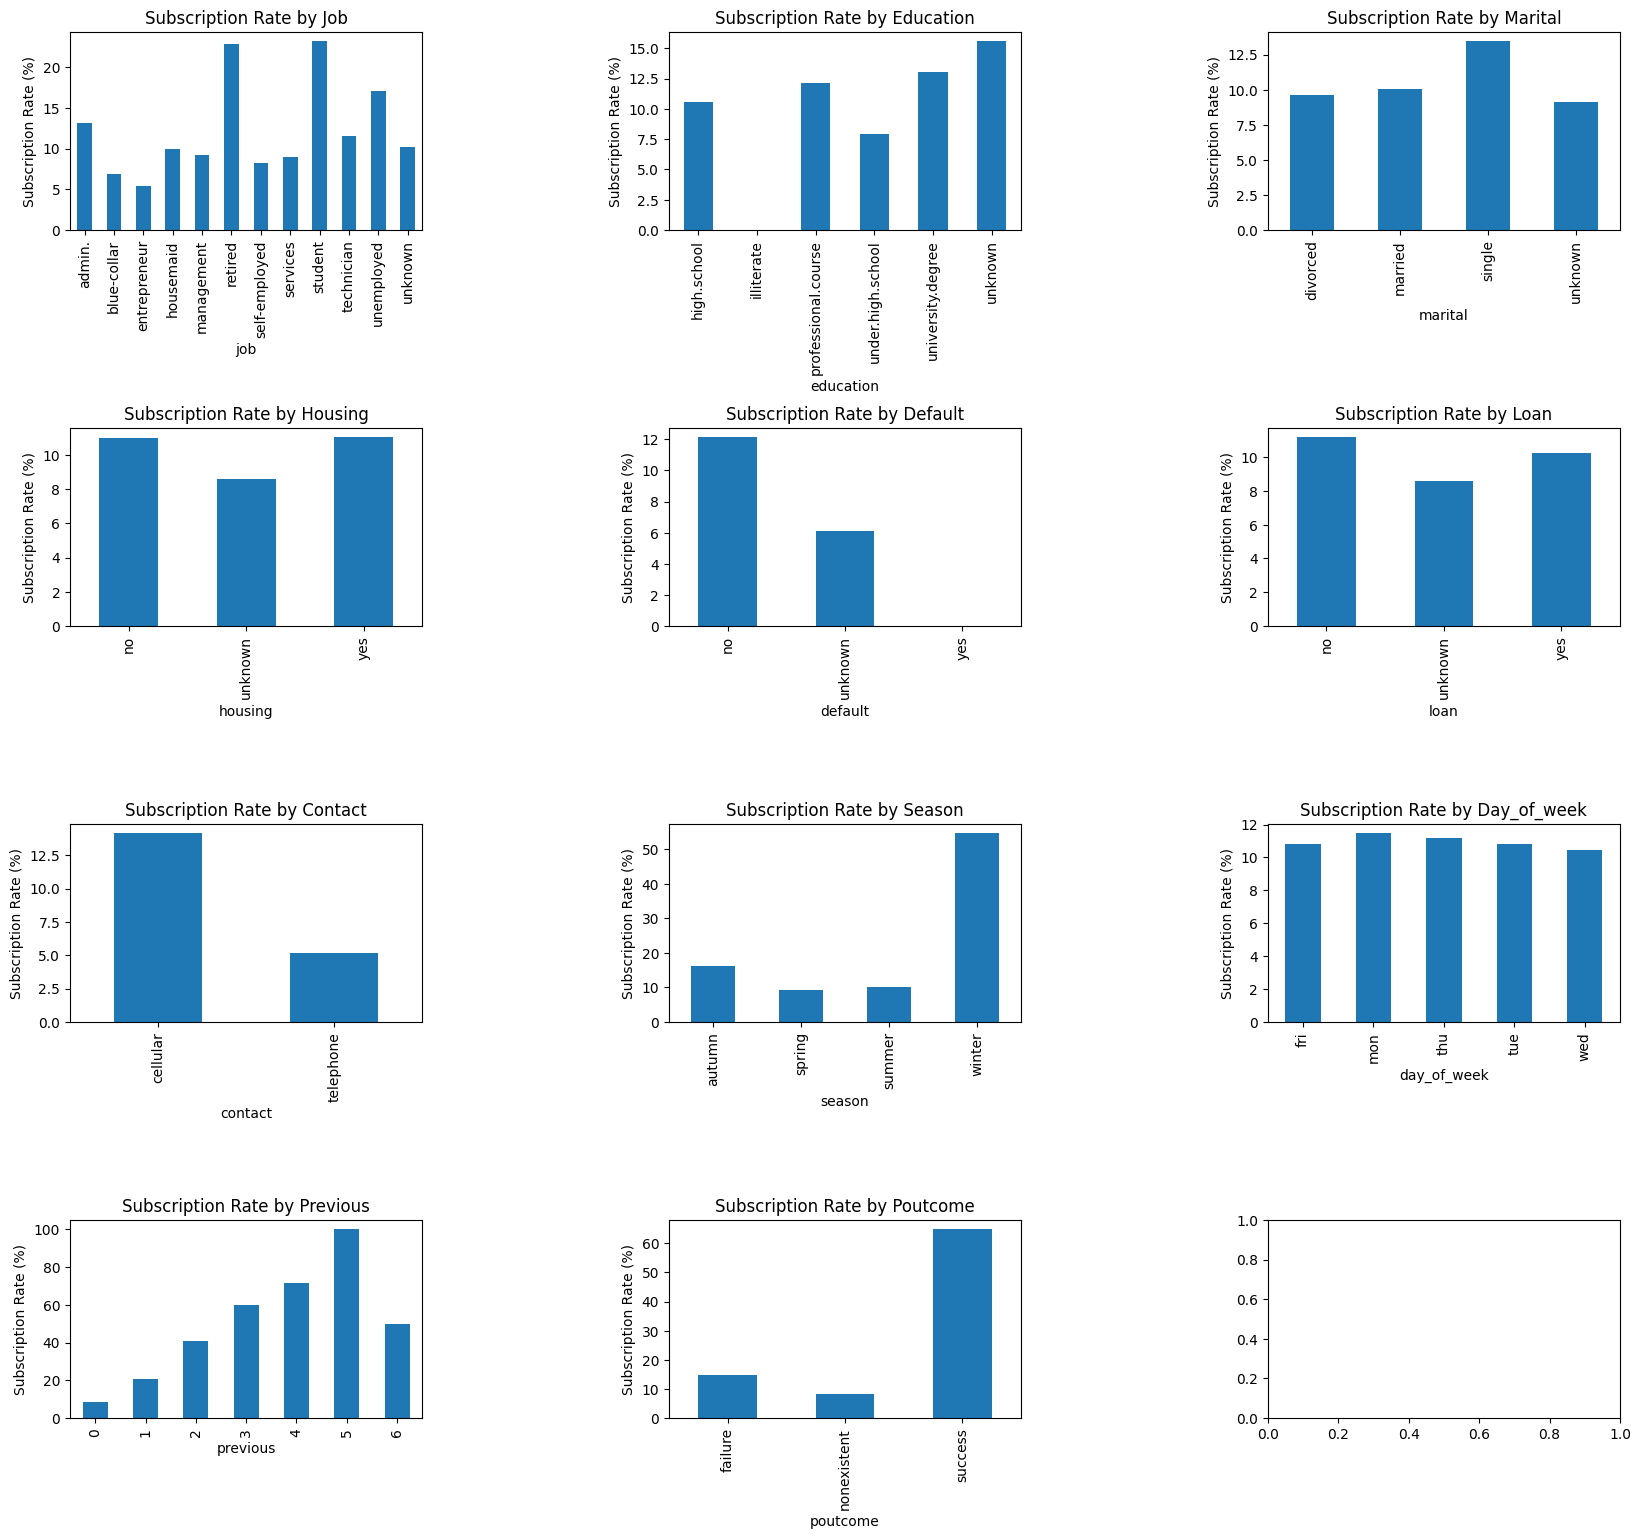

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Recalculate the data to reflect proportions within each group
def calculate_proportions(data, column):
    proportions = data.groupby(column)['y'].value_counts(normalize=True).unstack().fillna(0)
    proportions = proportions.multiply(100)  # Convert to percentages
    return proportions

variables = ['job', 'education', 'marital', 'housing', 'default', 'loan',
       'contact', 'season', 'day_of_week',  'previous',
       'poutcome',]

# Set up the matplotlib figure
fig, axes = plt.subplots(4,3, figsize=(20, 18))
fig.subplots_adjust(hspace=1, wspace=0.7)

for i, var in enumerate(variables):
    ax = axes.flatten()[i]
    proportions = calculate_proportions(data, var)
    proportions[['yes']].plot(kind='bar', stacked=True, ax=ax)  # Plot only the 'yes' proportion for clarity
    ax.set_title(f'Subscription Rate by {var.capitalize()}')
    ax.set_ylabel('Subscription Rate (%)')
    ax.legend().remove()

plt.show()

ValueError: Could not interpret value `age` for `x`. Value is a string, but `data` was not passed.

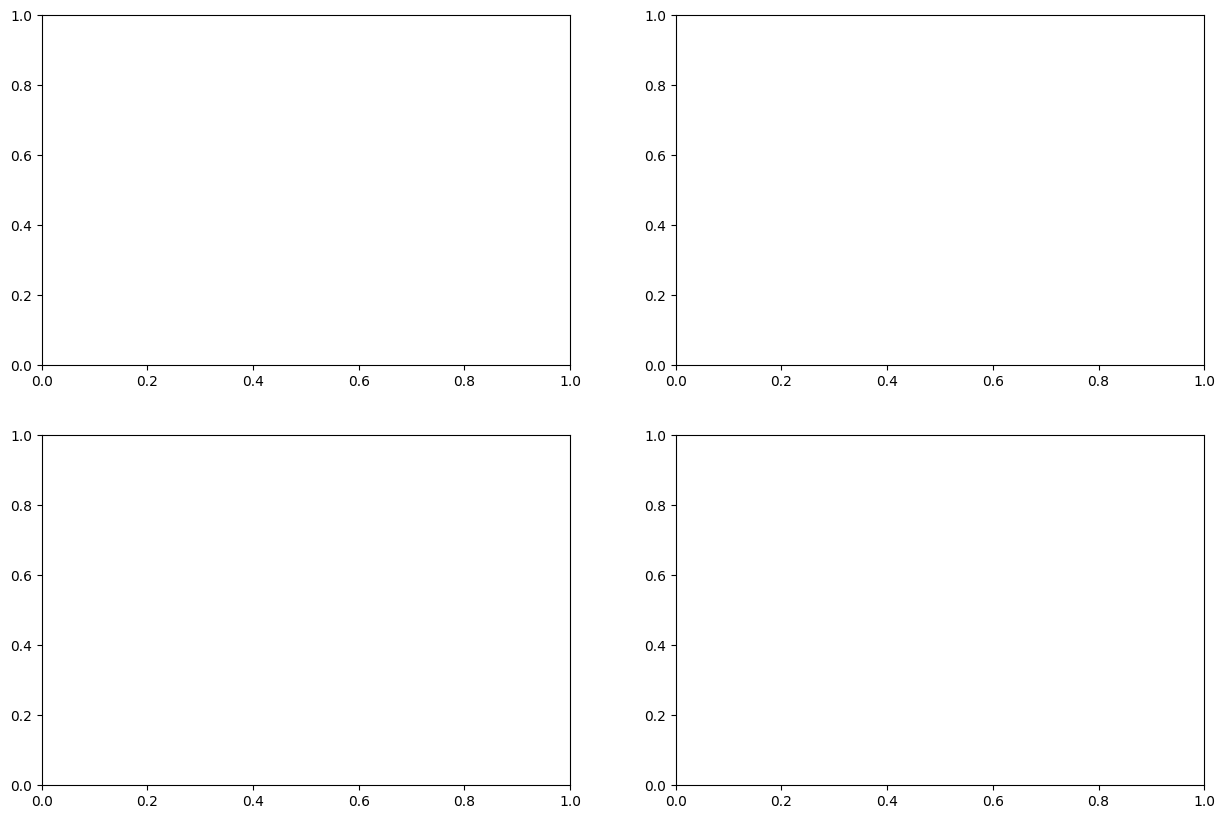

In [ ]:
import seaborn as sns

# Assuming the original 'y' column is still available and encoded as 'yes', 'no'
# If the execution state was reset, we'll reload the data and not re-encode the target variable for this visualization
data_v = data

# Convert 'y' into a binary variable for easier calculations of subscription rate
data_v['y_binary'] = data_v['y'].map({'yes': 1, 'no': 0})

# List of features to visualize
features_to_visualize = ['age', 'pdays', 'duration', 'previous']

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_visualize):
    # Calculate the mean subscription rate for each value/interval of the feature
    subscription_rate = data_v.groupby(feature)['y_binary'].mean().reset_index()

    sns.lineplot(x=feature, y='y_binary', data_v =subscription_rate, ax=axes[i], marker='o')
    axes[i].set_ylabel('Subscription Rate')
    axes[i].set_title(f'Subscription Rate by {feature}')
    axes[i].set_xlabel(feature)

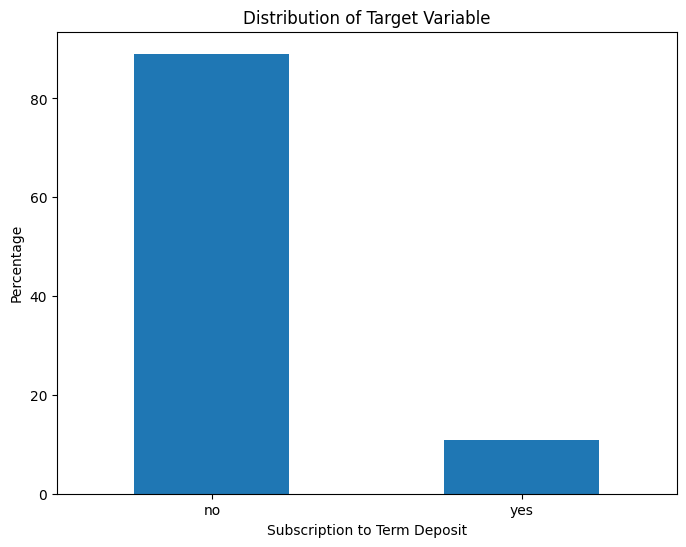

In [ ]:
# Calculate the distribution of the target variable 'y'
# Calculate the proportion of each class in 'y'
target_proportion = data['y'].value_counts(normalize=True) * 100
target_proportion

# Plot the distribution
plt.figure(figsize=(8, 6))
target_proportion.plot(kind='bar')
plt.title('Distribution of Target Variable')
plt.xlabel('Subscription to Term Deposit')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Columns to replace 'unknown' with the most frequent value
cols_replace_most_frequent = ['job', 'marital', 'education', 'housing', 'loan']

# Perform the replacement
for col in cols_replace_most_frequent:
    most_frequent_value = data[col].value_counts().idxmax()
    data[col] = data[col].replace('unknown', most_frequent_value)


In [ ]:
print(data['job'].unique())
print(data['marital'].unique())
print(data['education'].unique())
print(data['housing'].unique())
print(data['loan'].unique())
print(data['default'].unique())
print(data['season'].unique())

['blue-collar' 'services' 'admin.' 'entrepreneur' 'self-employed'
 'technician' 'management' 'student' 'retired' 'housemaid' 'unemployed']
['married' 'single' 'divorced']
['under.high.school' 'high.school' 'university.degree'
 'professional.course' 'illiterate']
['yes' 'no']
['no' 'yes']
['no' 'unknown' 'yes']
['spring' 'summer' 'autumn' 'winter']


In [ ]:
# Selecting features and target variable
X = data.drop('y', axis=1)
X['housing'] = data['housing'].map({'yes': 1, 'no': 0})
X['loan'] = data['loan'].map({'yes': 1, 'no': 0})
y = data['y'].map({'yes': 1, 'no': 0})  # Encoding the target variable

In [ ]:
# Identifying categorical columns
#categorical_cols = X.select_dtypes(include=['object']).columns

categorical_cols = ['job',	'marital',	'education',	'contact', 'day_of_week', 'poutcome','season', 'default']

# Applying OneHotEncoder to categorical columns
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = ohe.fit_transform(X[categorical_cols])
X_encoded = pd.DataFrame(X_encoded, columns=ohe.get_feature_names_out(categorical_cols))

# Dropping original categorical columns from X and adding the encoded ones
X.drop(categorical_cols, axis=1, inplace=True)
X.reset_index(drop=True, inplace=True)
X_encoded.reset_index(drop=True, inplace=True)
X_processed = pd.concat([X, X_encoded], axis=1)

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((3295, 47), (824, 47))

In [ ]:
X_train.columns

Index(['age', 'housing', 'loan', 'duration', 'campaign', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_under.high.school',
       'education_university.degree', 'contact_cellular', 'contact_telephone',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'season_autumn',
       'season_spring', 'season_summer', 'season_winter', 'default_no',
       'default_unknown', 'default_yes'],
      dtype='object')

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score

# Function to train and evaluate model
def train_evaluate_model(X_train, X_test, y_train, y_test):
    # Initialize the model
    model = XGBClassifier( eval_metric='aucpr',n_estimators=100, learning_rate= 0.03, max_depth = 5)

    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC score

    # Evaluation metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    aucpr = auc(recall_curve, precision)


    return precision ,recall_curve , roc_auc, f1, recall, aucpr, conf_matrix,  feature_importances ,  features

In [ ]:
# Model 1: Using all variables
precision ,recall_curve , roc_auc, f1, recall, aucpr, conf_matrix,  feature_importances ,  features = train_evaluate_model(X_train, X_test, y_train, y_test)
print(roc_auc, f1, recall, aucpr, conf_matrix)


# Preparing data for Model 2: Removing highly correlated variables
X_train_reduced = X_train.drop(columns=['euribor3m', 'nr.employed', 'emp.var.rate', 'cons.price.idx','cons.conf.idx'])
X_test_reduced = X_test.drop(columns=['euribor3m', 'nr.employed', 'emp.var.rate', 'cons.price.idx','cons.conf.idx'])

# Model 2: Using reduced set of variables
#precision ,recall_curve , roc_auc, f1, recall, aucpr, conf_matrix,  feature_importances ,  features = train_evaluate_model(X_train_reduced, X_test_reduced, y_train, y_test)
#print(roc_auc, f1, recall, aucpr, conf_matrix)

0.939712520788786 0.518987341772152 0.44565217391304346 0.6192580619692536 [[707  25]
 [ 51  41]]


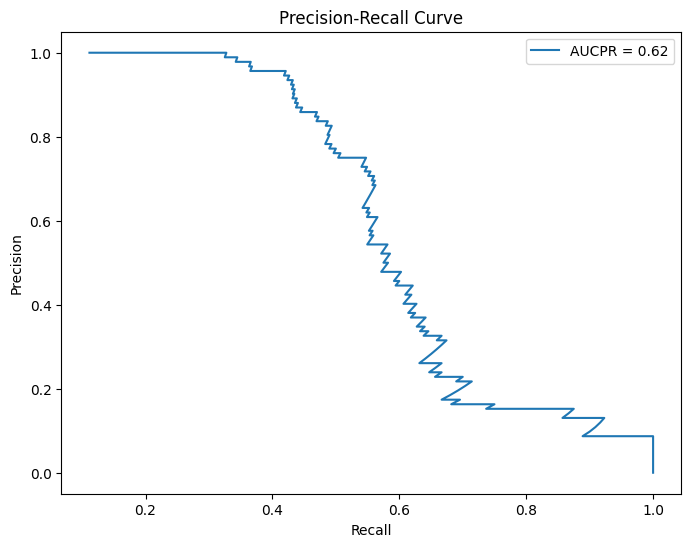

In [ ]:
# aucpr
plt.figure(figsize=(8, 6))
plt.plot(precision ,recall_curve, label=f'AUCPR = {aucpr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# Function to train and evaluate model
def train_evaluate_model(X_train, X_test, y_train, y_test):
    # Adjust class weights in the loss function for imbalanced data handling
    class_weights = y_train.value_counts(normalize=True).to_dict()
    weight = (1 / class_weights[1]) / (1 / class_weights[0])

    # Initialize and train XGBClassifier with adjusted class weight
    model = XGBClassifier(scale_pos_weight=weight, eval_metric='aucpr',n_estimators=100, learning_rate= 0.03, max_depth = 5 )

    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC score

    # Getting feature importances
    feature_importances = model.feature_importances_
    features = X_train.columns


    # Evaluation metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    aucpr = auc(recall_curve, precision)


    return precision ,recall_curve , roc_auc, f1, recall, aucpr, conf_matrix,  feature_importances ,  features

0.9355473390354003 0.5622775800711743 0.8586956521739131 0.6062931117247442 [[622 110]
 [ 13  79]]


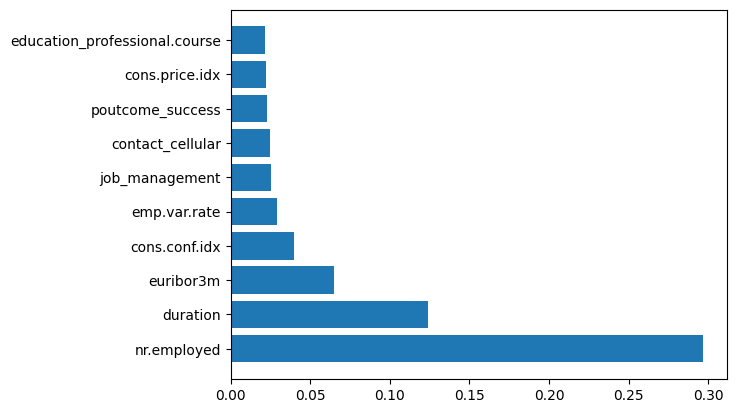

In [ ]:

# Model 1: Using all variables
precision ,recall_curve , roc_auc, f1, recall, aucpr, conf_matrix,  feature_importances ,  features= train_evaluate_model(X_train, X_test, y_train, y_test)
print(roc_auc, f1, recall, aucpr, conf_matrix)


# Preparing data for Model 2: Removing highly correlated variables
#X_train_reduced = X_train.drop(columns=['euribor3m', 'nr.employed', 'emp.var.rate', 'cons.price.idx','cons.conf.idx'])
#X_test_reduced = X_test.drop(columns=['euribor3m', 'nr.employed', 'emp.var.rate', 'cons.price.idx','cons.conf.idx'])

# Model 2: Using reduced set of variables
#roc_auc, f1, recall, aucpr, conf_matrix,  feature_importances ,   features = train_evaluate_model(X_train_reduced, X_test_reduced, y_train, y_test)
#print(roc_auc, f1, recall, aucpr, conf_matrix)


# Creating a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.barh(feature_importance_df['Feature'][:10],feature_importance_df['Importance'][:10])

plt.show()




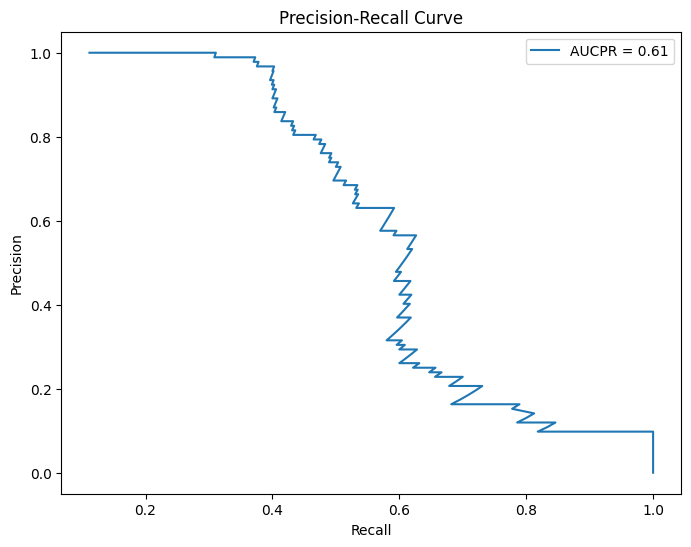

In [ ]:
# aucpr
plt.figure(figsize=(8, 6))
plt.plot(precision ,recall_curve, label=f'AUCPR = {aucpr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# Selecting only the highly correlated variables for PCA
features_for_pca = ['euribor3m', 'nr.employed', 'emp.var.rate', 'cons.price.idx','cons.conf.idx']
X_pca = X_processed[features_for_pca]

# Applying PCA to reduce the dimensionality
pca = PCA(n_components=2)  # Reduce to 1 dimension for simplicity
X_pca_transformed = pca.fit_transform(X_pca)

# Creating a new DataFrame with the PCA result
X_pca_df = pd.DataFrame(X_pca_transformed)

# Preparing the rest of the data (excluding the original highly correlated features)
X_rest = X_processed.drop(features_for_pca, axis=1)

# Combining the PCA feature with the rest of the data
X_combined = pd.concat([X_rest.reset_index(drop=True), X_pca_df], axis=1)

# Splitting the dataset into training and test sets with the combined data
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)


In [ ]:
# Model 2: Using reduced set of variables
precision ,recall_curve , roc_auc, f1, recall, aucpr, conf_matrix,  feature_importances ,  features = train_evaluate_model(X_train_combined, X_test_combined, y_train, y_test)
print(roc_auc, f1, recall, aucpr, conf_matrix,  feature_importances ,   features)

0.928872653837016 0.5428571428571428 0.8260869565217391 0.5974567032804807 [[620 112]
 [ 16  76]] [0.01761704 0.01371551 0.02021924 0.18752424 0.01262419 0.01533314
 0.00725765 0.01705693 0.02670346 0.         0.02219783 0.01273972
 0.01478433 0.02299748 0.01561445 0.02417027 0.01890123 0.02919272
 0.         0.0202481  0.02779341 0.         0.05720199 0.01003555
 0.01373749 0.03403809 0.         0.02791383 0.01125137 0.00552794
 0.02137784 0.02599082 0.01023651 0.         0.029519   0.01096314
 0.0084112  0.01091812 0.00244873 0.0180458  0.         0.
 0.15569091 0.02000083] Index([                          'age',                       'housing',
                                'loan',                      'duration',
                            'campaign',                      'previous',
                          'job_admin.',               'job_blue-collar',
                    'job_entrepreneur',                 'job_housemaid',
                      'job_management',             

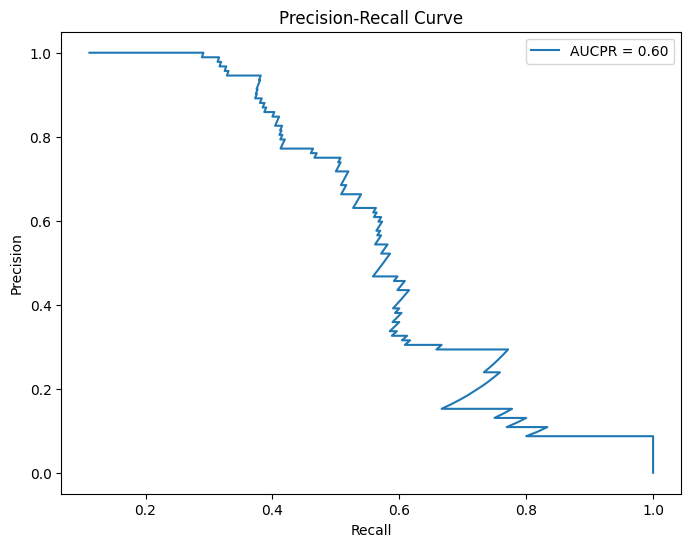

In [ ]:
# aucpr
plt.figure(figsize=(8, 6))
plt.plot(precision ,recall_curve, label=f'AUCPR = {aucpr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

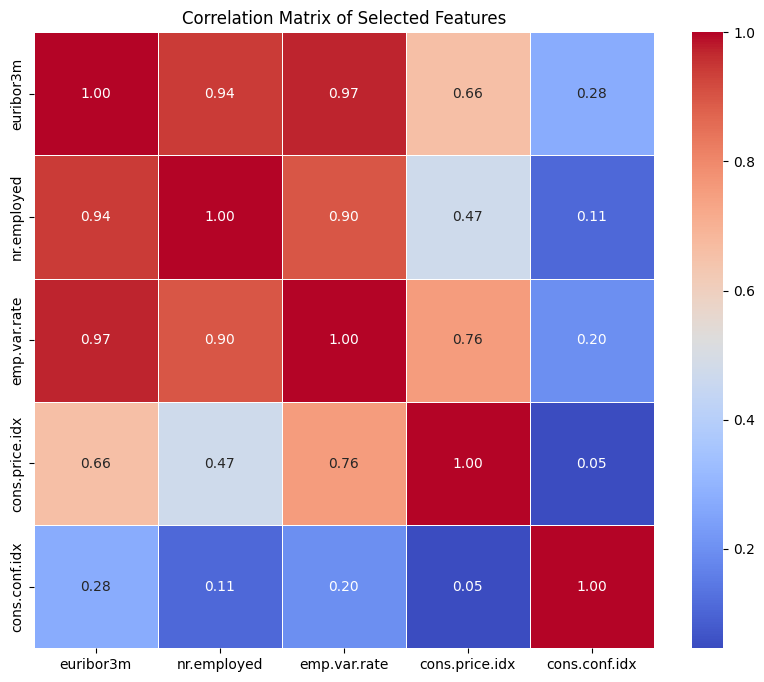

In [ ]:
# 選擇特定的特徵進行相關性分析
features_correlation = data[['euribor3m', 'nr.employed', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx']]

# 計算相關矩陣
correlation_matrix = features_correlation.corr()

# 使用Seaborn繪製熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [ ]:

# Selecting only the highly correlated variables for PCA
features_drop = ['nr.employed']


# Preparing the rest of the data (excluding the original highly correlated features)
X_droped = X_processed.drop(features_drop, axis=1)


# Splitting the dataset into training and test sets with the combined data
X_train_droped, X_test_droped, y_train, y_test = train_test_split(X_droped, y, test_size=0.2, random_state=42)


In [ ]:
X_droped.columns

Index(['age', 'housing', 'loan', 'duration', 'campaign', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_under.high.school', 'education_university.degree',
       'contact_cellular', 'contact_telephone', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'season_autumn', 'season_spring', 'season_summer',
       'season_winter', 'default_no', 'default_unknown', 'default_yes'],
      dtype='object')

0.9352652055119981 0.5563380281690141 0.8586956521739131 0.6060582455764426 [[619 113]
 [ 13  79]]


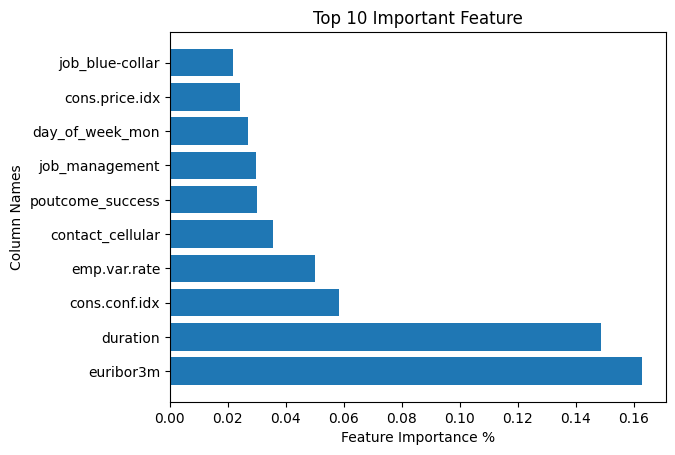

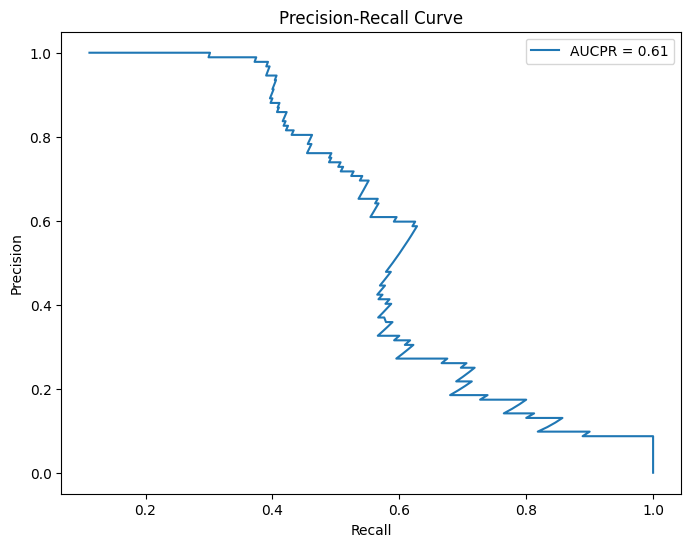

In [ ]:

# Model 1: Using all variables
precision ,recall_curve , roc_auc, f1, recall, aucpr, conf_matrix,  feature_importances ,  features = train_evaluate_model(X_train_droped, X_test_droped, y_train, y_test )
print(roc_auc, f1, recall, aucpr, conf_matrix)


# Creating a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.barh(feature_importance_df['Feature'][:10],feature_importance_df['Importance'][:10])
plt.title('Top 10 Important Feature')
plt.xlabel('Feature Importance %')
plt.ylabel('Column Names')
plt.xticks(rotation=0)
plt.show()


# aucpr
plt.figure(figsize=(8, 6))
plt.plot(precision ,recall_curve, label=f'AUCPR = {aucpr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
X_processed.columns


Index(['age', 'housing', 'loan', 'duration', 'campaign', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_under.high.school',
       'education_university.degree', 'contact_cellular', 'contact_telephone',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure',
       'poutcome_nonexistent', 'poutcome_success', 'season_autumn',
       'season_spring', 'season_summer', 'season_winter', 'default_no',
       'default_unknown', 'default_yes'],
      dtype='object')